## Setup Environment

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from prophet import Prophet
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [4]:
stations=pd.read_csv('citibike-stations.csv')
trips = pd.read_csv('citibike-trips-sample.csv')

In [5]:
trips['starttime'] = pd.to_datetime(trips['starttime'])
trips['stoptime'] = pd.to_datetime(trips['stoptime'])

In [6]:
trips['year'] = trips['starttime'].dt.year
trips['month'] = trips['starttime'].dt.month
trips['day'] = trips['starttime'].dt.day
trips['date'] = trips['starttime'].dt.date

In [7]:

trips['calc_duration']=(trips['stoptime']-trips['starttime']).astype('timedelta64[s]')
trips['duration_diff'] = abs(trips['calc_duration']-trips['tripduration'])

In [8]:
trips['h_distance'] = trips.apply(lambda x: utils.h_distance((x.start_station_latitude, x.start_station_longitude),(x.end_station_latitude, x.end_station_longitude)), axis=1)

## Profiling

In [9]:
trips.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                    int64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                      int64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                           object
birth_year                        float64
gender                             object
customer_plan                     float64
year                                int64
month                               int64
day                                 int64
date                               object
calc_duration                     float64
duration_diff                     float64
h_distance                        float64
dtype: object

In [10]:
trips.head(5)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,birth_year,gender,customer_plan,year,month,day,date,calc_duration,duration_diff,h_distance
0,2319,2016-03-09 13:08:00,2016-03-09 13:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,...,1972.0,male,NaN,2016,3,9,2016-03-09,2340.0,21.0,4.174902
1,313,2015-07-09 15:42:00,2015-07-09 15:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,...,1968.0,female,NaN,2015,7,9,2015-07-09,300.0,13.0,0.401914
2,906,2016-01-11 18:32:00,2016-01-11 18:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,...,1961.0,male,NaN,2016,1,11,2016-01-11,900.0,6.0,1.648286
3,716,2013-10-30 11:53:00,2013-10-30 12:05:00,520,W 52 St & 5 Ave,40.759923,-73.976485,533,Broadway & W 39 St,40.752996,...,1954.0,male,NaN,2013,10,30,2013-10-30,720.0,4.0,0.742178
4,312,2014-06-04 16:12:00,2014-06-04 16:17:00,520,W 52 St & 5 Ave,40.759923,-73.976485,519,E 42 St & Vanderbilt Ave,40.752416,...,1963.0,male,NaN,2014,6,4,2014-06-04,300.0,12.0,0.531039


In [11]:
trips.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,customer_plan,year,month,day,calc_duration,duration_diff,h_distance
count,3.157850e+05,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,276894.000000,0.0,315785.000000,315785.000000,315785.000000,3.157850e+05,315785.000000,315785.000000
mean,9.384988e+02,638.426236,40.735735,-73.989392,631.766471,40.735366,-73.989326,19074.896870,1976.528812,NaN,2014.693956,7.100112,15.832034,9.388082e+02,19.995288,1.106254
std,6.534950e+03,772.408824,0.020822,0.014088,762.145089,0.075412,0.132420,2888.180823,11.449689,NaN,1.036277,2.804010,8.669115,6.534471e+03,17.950997,9.671095
min,6.000000e+01,72.000000,40.646678,-74.017134,72.000000,0.000000,-74.017134,14529.000000,1885.000000,NaN,2013.000000,1.000000,1.000000,-2.940000e+03,0.000000,0.000000
25%,3.910000e+02,312.000000,40.721101,-73.999318,312.000000,40.720874,-73.999744,16687.000000,1969.000000,NaN,2014.000000,5.000000,8.000000,4.200000e+02,8.000000,0.537872
50%,6.310000e+02,428.000000,40.736529,-73.990093,427.000000,40.736502,-73.990214,18779.000000,1979.000000,NaN,2015.000000,7.000000,16.000000,6.600000e+02,18.000000,0.869205
75%,1.051000e+03,501.000000,40.750977,-73.981281,499.000000,40.750664,-73.981346,21090.000000,1986.000000,NaN,2016.000000,9.000000,23.000000,1.080000e+03,30.000000,1.409421
max,1.733173e+06,3425.000000,40.804213,-73.929891,3427.000000,40.804213,0.000000,26884.000000,2000.000000,NaN,2016.000000,12.000000,31.000000,1.733160e+06,3652.000000,5416.876458


In [12]:
trips.isna().sum()

tripduration                    0
starttime                       0
stoptime                        0
start_station_id                0
start_station_name              0
start_station_latitude          0
start_station_longitude         0
end_station_id                  0
end_station_name                0
end_station_latitude            0
end_station_longitude           0
bikeid                          0
usertype                        0
birth_year                  38891
gender                          0
customer_plan              315785
year                            0
month                           0
day                             0
date                            0
calc_duration                   0
duration_diff                   0
h_distance                      0
dtype: int64

## Gender Exploration

In [13]:
trips.gender.value_counts(normalize=True)

male       0.670367
female     0.205478
unknown    0.124154
Name: gender, dtype: float64

## Age Explroration

## Distance Exploration

## Duration Exploration

In [14]:
max_duration = 24*60*60

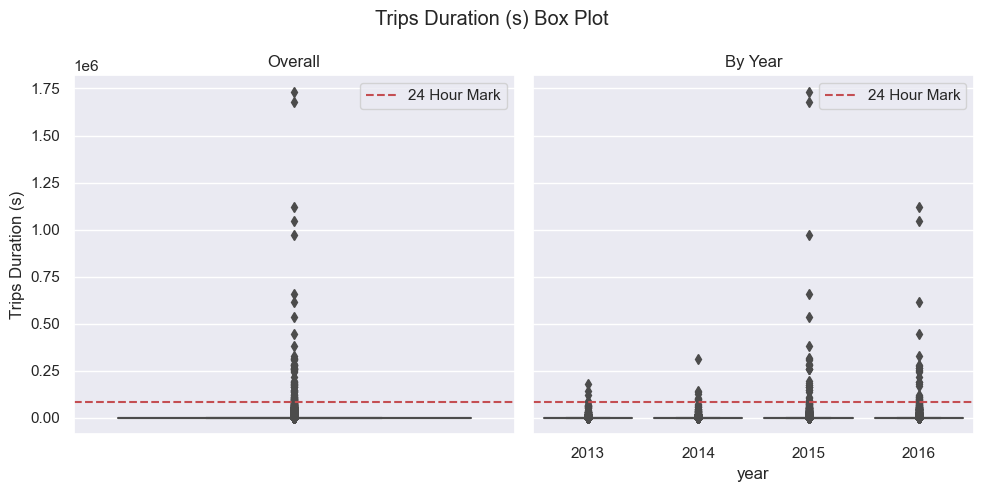

In [15]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

sns.boxplot(y=trips.tripduration, ax=axes[0])
axes[0].axhline(max_duration, linestyle='--', label='24 Hour Mark', color='r')
axes[0].set_title("Overall")
axes[0].set_ylabel("Trips Duration (s)")
axes[0].legend()

sns.boxplot(data=trips, y="tripduration", x="year", ax=axes[1])
axes[1].axhline(max_duration, linestyle='--', label='24 Hour Mark', color='r')
axes[1].set_ylabel("")
axes[1].set_yticklabels([])
axes[1].set_title("By Year")

axes[1].legend()

fig.suptitle("Trips Duration (s) Box Plot")
fig.tight_layout()

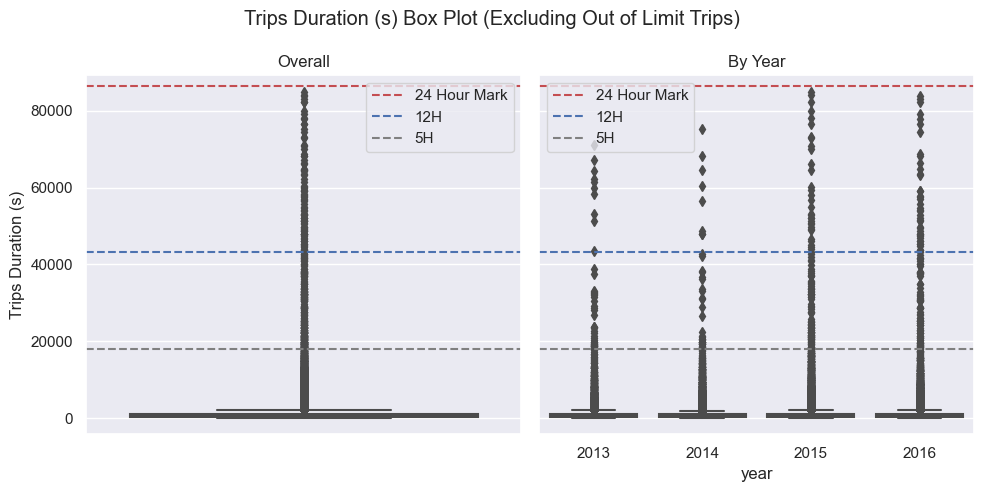

In [16]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
df_temp = trips.loc[trips.tripduration<=max_duration]
sns.boxplot(y=df_temp.tripduration, ax=axes[0])
axes[0].axhline(max_duration, linestyle='--', label='24 Hour Mark', color='r')
axes[0].axhline(12*60*60, linestyle='--', label='12H')
axes[0].axhline(5*60*60, linestyle='--', label='5H', color='gray')
axes[0].set_title("Overall")
axes[0].set_ylabel("Trips Duration (s)")
axes[0].legend()

sns.boxplot(data=df_temp, y="tripduration", x="year", ax=axes[1])
axes[1].axhline(max_duration, linestyle='--', label='24 Hour Mark', color='r')
axes[1].axhline(12*60*60, linestyle='--', label='12H')
axes[1].axhline(5*60*60, linestyle='--', label='5H', color='gray')
axes[1].set_title("By Year")
axes[1].set_ylabel("")
axes[1].set_yticklabels([])
axes[1].legend()

fig.suptitle("Trips Duration (s) Box Plot (Excluding Out of Limit Trips)")
fig.tight_layout()

In [17]:
trips.loc[trips.tripduration>max_duration].shape

(72, 23)

In [18]:
trips.loc[trips.tripduration>max_duration].duration_diff.mean()

69.76388888888889

In [19]:
trips.loc[trips.tripduration>max_duration].duration_diff.max()

3652.0

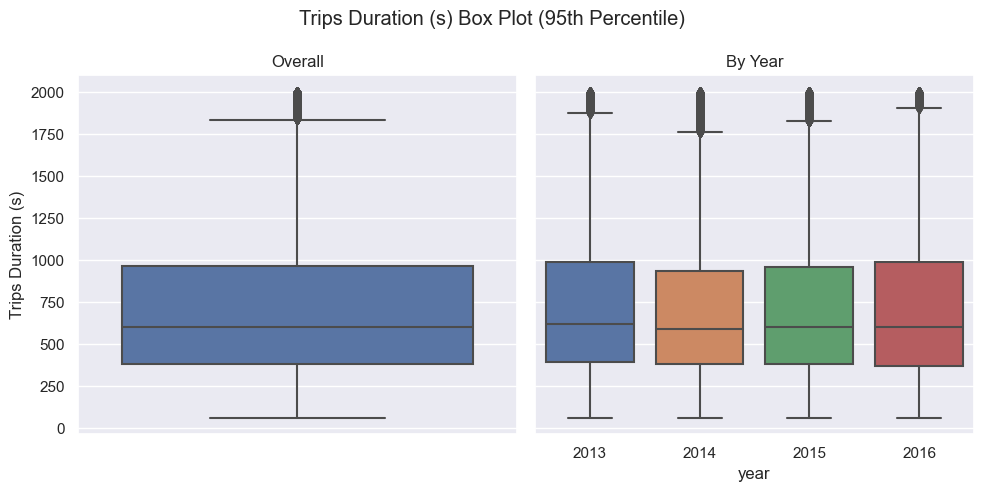

In [20]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
df_temp = trips[trips.tripduration < np.percentile(trips.tripduration,95)].loc[(trips.tripduration<=max_duration)]
sns.boxplot(y=df_temp.tripduration, ax=axes[0])
axes[0].set_title("Overall")
axes[0].set_ylabel("Trips Duration (s)")

sns.boxplot(data=df_temp, y="tripduration", x="year", ax=axes[1])
axes[1].set_title("By Year")
axes[1].set_ylabel("")
axes[1].set_yticklabels([])

fig.suptitle("Trips Duration (s) Box Plot (95th Percentile)")
fig.tight_layout()


In [21]:
trips_2 = trips[trips.tripduration < np.percentile(trips.tripduration,95)].loc[(trips.tripduration<=max_duration)]


## Number of Daily Trips

In [22]:
agg = trips_2.groupby(['date']).size()

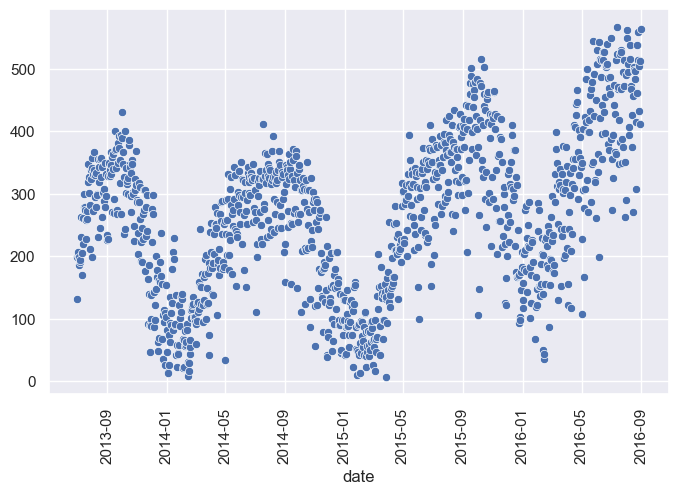

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
sc = sns.scatterplot(agg, ax=ax)
ax.tick_params(axis='x', rotation=90)

16:13:28 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing


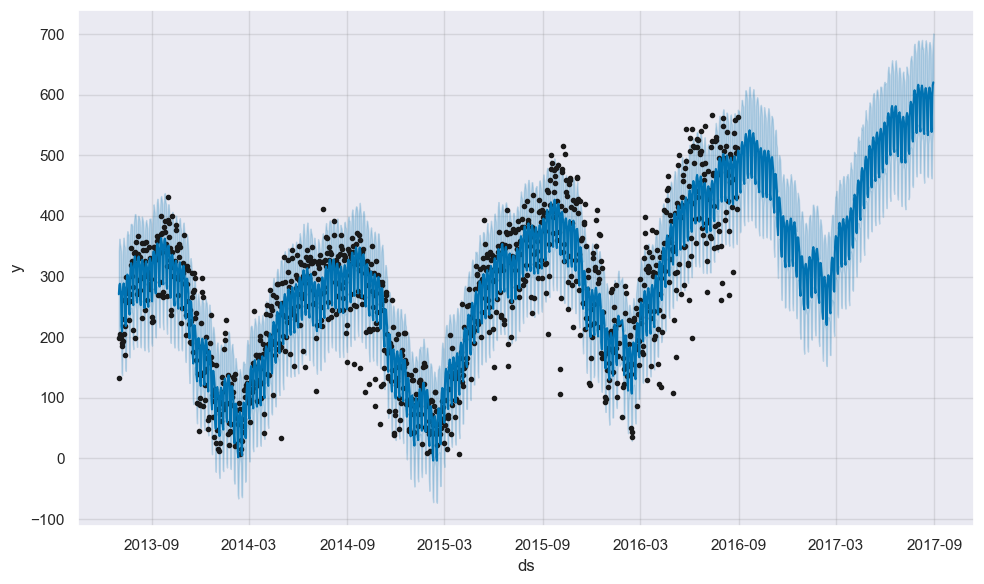

In [93]:
df = agg.reset_index().rename({'date':'ds',0:'y'},axis=1)
m = Prophet(changepoint_range=0.95)
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [94]:
# fig2 = m.plot_components(forecast)

In [95]:
df_pred  = pd.concat([forecast,df], axis=1)
df_pred = df_pred.loc[~df_pred.y.isna()]
df_pred = df_pred.loc[:,~df_pred.columns.duplicated()].copy()

In [96]:
df_pred['Upper Outlier'] = np.where(df_pred['y']>df_pred['yhat_upper'],1,0)
df_pred['Lower Outlier'] = np.where(df_pred['y']<df_pred['yhat_lower'],1,0)
df_pred['Outlier'] = df_pred['Upper Outlier'] |df_pred['Lower Outlier'] 

In [97]:
df_pred['Outlier'].sum()/df_pred['Outlier'].shape[0]

0.16999132697311362

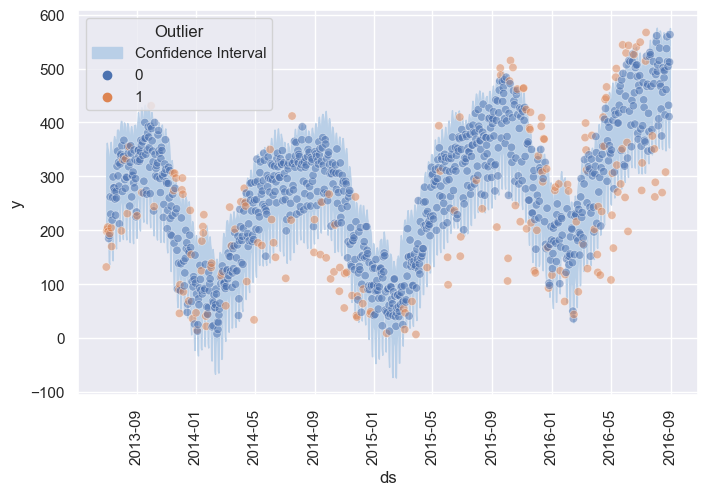

In [98]:
fig, ax = plt.subplots(figsize=(8,5))
ax.fill_between(df_pred.ds, df_pred.yhat_lower, df_pred.yhat_upper, color="#b9cfe7", label='Confidence Interval')

sns.scatterplot(data=df_pred, x='ds',y='y', ax=ax, marker='o', alpha=0.5, hue='Outlier')
# sns.scatterplot(data=df_pred, x='ds',y='yhat', ax=ax, label='Prediction', marker='o', alpha=0.5)

ax.tick_params(axis='x', rotation=90)

In [67]:
df_pred.y

0       132.0
1       198.0
2       202.0
3       206.0
4       198.0
        ...  
1148    504.0
1149    432.0
1150    411.0
1151    512.0
1152    563.0
Name: y, Length: 1153, dtype: float64